In [1]:
import sys
import pandas as pd
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
sys.path.append("C:/dev/pyktrader3/")
from pycmqlib3.utility import misc
from bktest import backtest
import pycmqlib3.analytics.data_handler as dh

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF", 'nr']
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'SA'] # 'CY', 
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts
daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 5, 1), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1)}
min_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2011,1,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2014,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,5,1),  'sn':datetime.date(2017,4,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 8, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 1, 1), 'eg': datetime.date(2019, 5, 1), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 5, 1), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),}

In [43]:
# asset = 'IF'
# use_args = {'roll_rule': '0b', 'freq': 'd', 
#             'shift_mode': 0, 
#             'dbtbl_prefix': '', 
#             'start_date': datetime.date(2015, 9, 1), 
#             'end_date': datetime.date(2021, 10, 19), 
#             'n': 2}
# udf = misc.nearby(asset, **use_args)
# print(udf.tail())


In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']
factor_list = ['lrstd','upstd','lrskew','lrkurt','mincnt','volmf','oimf','trdstr','volmfratio']
shared_cols = ['date', 'split_idx']
start_date = datetime.date(2011, 1, 1)
end_date = datetime.date(2021, 12, 31)
pnl_tenors = ['1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']

delimiter = '-'
atr_win = 20
file_folder = "C:\\dev\\data\\data_cache\\"

sim_products = ind_all_mkts + ags_all_mkts # ['IF', 'IH', 'IC', 'TF', 'T'] #
shift_mode = 1
freq = 'd'

if freq == 'd':
    sim_start_dict = daily_start_dict
else:
    sim_start_dict = min_start_dict
    
dbtbl_prefix = ''
args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
base2_args = {'roll_rule': '-40b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
v_args  = {'roll_rule': '-28b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
sc_args = {'roll_rule': '-20b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
eq_args = {'roll_rule': '-1b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
bond_args = {'roll_rule': '-30b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}
precious_args = {'roll_rule': '-25b', 'freq': freq, 'shift_mode': shift_mode, 'dbtbl_prefix': dbtbl_prefix}

df_list = []

for idx, asset in enumerate(sim_products):
    use_args = copy.copy(args)
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['ni']:
        use_args = base2_args
    elif asset in ['sc']:
        use_args = sc_args
    elif asset in ['v']:
        use_args = v_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(sim_start_dict.get(asset, start_date), start_date)
    use_args['end_date'] = end_date        
    for idy, nb in enumerate([1, 2]):
        if freq == 'd':
            use_args['n'] = nb
            print("loading mkt = %s, nb = %s, args = %s" % (asset, nb, use_args))
            df = misc.nearby(asset, **use_args)
            df.index.name = 'date'
            xdf = df[field_list]
        else:
            filename = "%s_%s_%s_%s.csv" % (asset, nb, freq, end_date.strftime("%Y%m%d"))
            df = pd.read_csv(file_folder + filename, index_col=0)
            df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))            
            df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
            df = df.drop_duplicates(subset=['date', 'split_idx'], keep='last').set_index(['date', 'split_idx'])
            df = df.drop(['cum_idx'], axis=1)
            ep_field = [ col for col in df.columns if 'exec_price' in col]
            xdf = df[field_list + ep_field + factor_list]
            #xdf['expiry'] = xdf['contract'].apply(lambda x: misc.contract_expiry(x, misc.CHN_Holidays))
        xdf['contmth'] = xdf['contract'].apply(lambda x: misc.inst2contmth(x))
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100)        
        xdf.columns = [delimiter.join((asset+str(nb), col)) for col in xdf.columns]
        df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).sort_index()
if freq == 'd':
    df.index.name = 'date'
df = df.reset_index()
if freq != 'd':
    df['date'] = df['date'].dt.date

print(df.tail(20))


loading mkt = rb, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2011, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = rb, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2011, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = hc, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2016, 4, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = hc, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2016, 4, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = i, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2014, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = i, nb = 2, a

loading mkt = TA, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2012, 4, 15), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = TA, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2012, 4, 15), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = MA, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2012, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = MA, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2012, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = bu, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2015, 9, 15), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = bu, nb =

loading mkt = AP, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2018, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = AP, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2018, 1, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = sp, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 5, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = sp, nb = 2, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 5, 1), 'end_date': datetime.date(2021, 12, 31), 'n': 2}
loading mkt = CJ, nb = 1, args = {'roll_rule': '-30b', 'freq': 'd', 'shift_mode': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2019, 8, 9), 'end_date': datetime.date(2021, 12, 31), 'n': 1}
loading mkt = CJ, nb = 2,

In [4]:
def run_ts_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    run_mode = input_args.get('run_mode', "ryield")
    params = input_args.get('params', [0.0, 0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    total_risk = input_args.get('total_risk', 5000000.0)
    asset_scaling = input_args.get('asset_scaling', False)
    exec_field = input_args.get('exec_field', 'open')
    select_cols = []
    data_field = ''
    pos_func, pos_args, _ = input_args.get('pos_map', (None, {}, ''))    
    
    for col in df.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if col_split[0][:-1] in product_list:
                select_cols.append(col)

    xdf= df[select_cols].copy(deep = True)
    if start_date:
        xdf = xdf[xdf['date']>= start_date]
    if end_date:
        xdf = xdf[xdf['date']<= end_date]
    for asset in product_list:
        if shift_mode == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif shift_mode == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'mom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'upratio'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).agg(lambda x: (x>0).sum()/win) - 0.5 
        
        for field in reverse_list:
            if field in run_mode:                
                if delimiter.join((asset + str(1), field)) in xdf.columns:
                    xdf[delimiter.join((asset + str(1), field))] = - xdf[delimiter.join((asset + str(1), field))]
                else:
                    print("Field=%s is not in dataframe." % field)
                break      

        if 'rsi' in run_mode:
            rsi_output = dh.RSI_F(xdf, win, prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'rsi'))] = rsi_output[asset + str(1) + delimiter + 'RSI' + str(win)]
        elif 'clbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'clbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)
        elif 'hlbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'high'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'low'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'hlbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)                    
        elif 'macd' in run_mode:
            xdf[delimiter.join((asset + str(1), 'ema1'))] = dh.EMA(xdf, win, field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'ema2'))] = dh.EMA(xdf, int(win * params[0]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'mstd'))] = dh.STDEV(xdf, int(win * params[1]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'macd'))] = (xdf[delimiter.join((asset + str(1), 'ema1'))] - xdf[delimiter.join((asset + str(1), 'ema2'))])/xdf[delimiter.join((asset + str(1), 'mstd'))]
        elif run_mode == 'mixmom':
            xdf[delimiter.join((asset + str(1), 'mixmom'))] = (xdf[delimiter.join((asset + str(1), 'mom'))] * xdf[delimiter.join((asset + str(1), 'upratio'))]).apply(lambda x: x if x>0 else 0) \
                                                              * xdf[delimiter.join((asset + str(1), 'mom'))].apply(lambda x: misc.sign(x)) 
        data_field = run_mode
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if shift_mode == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill')
            elif shift_mode == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        if 'sma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'ema' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'xma' == run_mode[-3:]:   
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'xea' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nmb' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.BSTDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'zlv' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = (xdf[delimiter.join((asset + str(1), ref_field))] \
                                                                 - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()) \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        if pos_func:
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), data_field))].apply(lambda x: pos_func(x, **pos_args))

    select_cols = []
    for col in xdf.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if (col_split[0] in mod_prod_list):
                select_cols.append(col)    
    
    adf = xdf[select_cols].copy()
    fdf = adf[[delimiter.join((asset, data_field)) for asset in mod_prod_list]]
    adf['prod_count'] = fdf.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1)
    if asset_scaling:
        adf['scaling'] = 30.0/adf['prod_count']
    else:
        adf['scaling'] = 1.0
    adf['rebal_seqno'] = range(len(adf.index))
    
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            pflag = (adf[delimiter.join((asset, data_field))] >= 0) & rebal_flag
            nflag = (adf[delimiter.join((asset, data_field))] <= 0) & rebal_flag
            long_tmp.loc[pflag, asset] = adf.loc[pflag, delimiter.join((asset, data_field))]
            long_tmp.loc[nflag, asset] = 0.0
            short_tmp.loc[nflag, asset] = -adf.loc[nflag, delimiter.join((asset, data_field))]
            short_tmp.loc[pflag, asset] = 0.0 
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_pos = long_pos + long_tmp/rebal_freq
        short_pos = short_pos + short_tmp/rebal_freq
    
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []
    dpnl_by_asset = []
    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk * adf['scaling']  \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        short_pos[asset] = (short_pos[asset] * total_risk * adf['scaling'] \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, exec_field))]
        #adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1).fillna(0.0)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        elif 's' in freq:
            tdf['date'] = adf['date']
            tdf['split_idx'] = adf['split_idx']
        elif freq == 'd':
            tdf['date'] = adf['date']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
        (res_pnl, ts) = backtest.get_pnl_stats([tdf], margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
        dpnl_by_asset.append(ts['daily_pnl'])
    dpnl_df = pd.concat(dpnl_by_asset, join='outer', sort = False, axis=1)
    dpnl_df = dpnl_df.fillna(method='ffill').fillna(0.0)
    dpnl_df.columns = mod_prod_list
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df, 'dpnl': dpnl_df}
    return res


In [6]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    mom_win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    quantile_cutoff = input_args['quantile']
    run_mode = input_args.get('run_mode', "momma")
    params = input_args.get('params', [0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    total_risk = input_args.get('total_risk', 5000000.0)
    asset_scaling = input_args.get('asset_scaling', False)
    select_cols = []
    pos_func, pos_args, _ = input_args.get('pos_map', (None, {}, ''))
    exec_field = input_args.get('exec_field', 'open')

    for col in df.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if col_split[0][:-1] in product_list:
                select_cols.append(col)

    xdf= df[select_cols].copy(deep = True)
    if start_date:
        xdf = xdf[xdf['date'] >= start_date]
    if end_date:
        xdf = xdf[xdf['date'] <= end_date]

    for asset in product_list:
        if shift_mode == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif shift_mode == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'mom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum()
        xdf[delimiter.join((asset + str(1), 'upratio'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).agg(lambda x: (x>0).sum()/win)
        
        for field in reverse_list:
            if field in run_mode:
                if delimiter.join((asset + str(1), field)) in xdf.columns:
                    xdf[delimiter.join((asset + str(1), field))] = - xdf[delimiter.join((asset + str(1), field))]
                else:
                    print("Field=%s is not in dataframe." % field)
                break            
        
        if 'rsi' in run_mode:
            rsi_output = dh.RSI_F(xdf, win, prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'rsi'))] = rsi_output[asset + str(1) + delimiter + 'RSI' + str(win)]
        elif 'clbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'close'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'clbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)
        elif 'hlbrk' in run_mode:
            chmax = xdf[delimiter.join((asset + str(1), 'high'))].rolling(win).max()
            chmin = xdf[delimiter.join((asset + str(1), 'low'))].rolling(win).min()
            chavg = (chmax + chmin)/2.0
            xdf[delimiter.join((asset + str(1), 'hlbrk'))] = (xdf[delimiter.join((asset + str(1), 'close'))] - chavg)/(chmax - chmin)                
        elif 'macd' in run_mode:
            xdf[delimiter.join((asset + str(1), 'ema1'))] = dh.EMA(xdf, win, field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'ema2'))] = dh.EMA(xdf, int(win * params[0]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'mstd'))] = dh.STDEV(xdf, int(win * params[1]), field = 'close', prefix = asset + str(1) + delimiter)
            xdf[delimiter.join((asset + str(1), 'macd'))] = (xdf[delimiter.join((asset + str(1), 'ema1'))] - xdf[delimiter.join((asset + str(1), 'ema2'))])/xdf[delimiter.join((asset + str(1), 'mstd'))]
        elif run_mode == 'mixmom':
            xdf[delimiter.join((asset + str(1), 'mixmom'))] = (xdf[delimiter.join((asset + str(1), 'mom'))] * xdf[delimiter.join((asset + str(1), 'upratio'))]).apply(lambda x: x if x>0 else 0) \
                                                              * xdf[delimiter.join((asset + str(1), 'mom'))].apply(lambda x: misc.sign(x))
        data_field = run_mode
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if shift_mode == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill')
            elif shift_mode == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        if 'sma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'ema' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'xma' == run_mode[-3:]:   
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()
        elif 'xea' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            - dh.EMA(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)

        elif 'nma' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'nmb' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = xdf[delimiter.join((asset + str(1), ref_field))] \
                                                            / dh.BSTDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
        elif 'zlv' == run_mode[-3:]:
            ref_field = run_mode[:-3]
            xdf[delimiter.join((asset + str(1), data_field))] = (xdf[delimiter.join((asset + str(1), ref_field))] \
                                                                 - xdf[delimiter.join((asset + str(1), ref_field))].rolling(ma_win).mean()) \
                                                            / dh.STDEV(xdf, ma_win, field = ref_field, prefix = asset + str(1) + delimiter)
    select_cols = []
    for col in xdf.columns:
        if col in shared_cols:
            select_cols.append(col)
        else:
            col_split = col.split(delimiter)
            if (col_split[0] in mod_prod_list):
                select_cols.append(col)    
    
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0
    
    rank_field = run_mode
    adf = xdf[select_cols].copy()
    rank_df = adf[[delimiter.join((asset, rank_field)) for asset in mod_prod_list]].rank(axis=1)
    rank_df.columns = mod_prod_list
    
    adf['prod_count'] = rank_df.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1).fillna(0)
    if asset_scaling:
        adf['scaling'] = 30.0/adf['prod_count']
    else:
        adf['scaling'] = 1.0
    adf['kcut'] = (adf['prod_count'] * quantile_cutoff).astype('int')
    adf['upper_rank'] = adf['prod_count'] - adf['kcut']
    adf['lower_rank'] = adf['kcut'] + 1 
    adf['rebal_seqno'] = range(len(adf.index))

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            long_tmp.loc[(rank_df[asset]>adf['upper_rank']) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=adf['upper_rank']) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<adf['lower_rank']) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=adf['lower_rank']) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        #long_sum = long_tmp.sum(axis=1)
        #short_sum = short_tmp.sum(axis=1)        
        long_pos = long_pos + long_tmp/ rebal_freq #.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp/ rebal_freq  #.div(short_sum,axis=0)
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []
    dpnl_by_asset = []
    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk * adf['scaling'] \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk * adf['scaling']\
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, exec_field))]
        #adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1).fillna(0.0)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        elif 's' in freq:
            tdf['date'] = adf['date']
            tdf['split_idx'] = adf['split_idx']
        elif freq == 'd':
            tdf['date'] = adf['date']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
        (res_pnl, ts) = backtest.get_pnl_stats([tdf], margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
        dpnl_by_asset.append(ts['daily_pnl'])
    dpnl_df = pd.concat(dpnl_by_asset, join='outer', sort = False, axis=1)
    dpnl_df = dpnl_df.fillna(method='ffill').fillna(0.0)
    dpnl_df.columns = mod_prod_list
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df, 'dpnl': dpnl_df}
    return res

In [7]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]

#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

<ipython-input-8-431f05d865ac>:60: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  port_pnl = pd.Series()
<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


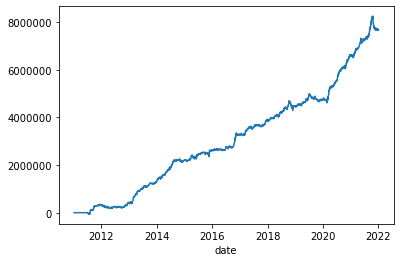

                 tscarry-ryieldnmb-commod_mkts-1-120-1-0.2
sharp_ratio_10y                                   2.387099
sharp_ratio_1y                                    2.099121
sharp_ratio_2y                                    3.182203
sharp_ratio_3y                                    2.611306
sharp_ratio_4y                                    2.446018
sharp_ratio_5y                                    2.413521
sharp_ratio_6y                                    2.407433
sharp_ratio_7y                                    2.290364
sharp_ratio_8y                                    2.402882
sharp_ratio_9y                                    2.521731
std_pnl_10y                                   20227.688387
std_pnl_1y                                    33665.901252
std_pnl_2y                                    30039.494861
std_pnl_3y                                    26609.176956
std_pnl_4y                                    25524.165523
std_pnl_5y                                    23871.8267

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


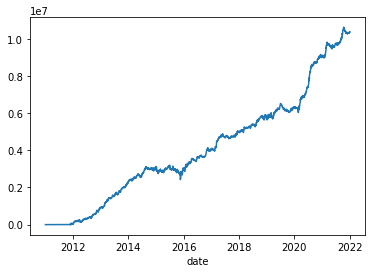

                 tscarry-basmomnma-commod_mkts-100-120-1-0.2
sharp_ratio_10y                                     2.138299
sharp_ratio_1y                                      2.172567
sharp_ratio_2y                                      3.315861
sharp_ratio_3y                                      2.574725
sharp_ratio_4y                                      2.406976
sharp_ratio_5y                                      2.383419
sharp_ratio_6y                                      2.369518
sharp_ratio_7y                                      1.939495
sharp_ratio_8y                                      1.940655
sharp_ratio_9y                                      2.099451
std_pnl_10y                                     31642.931714
std_pnl_1y                                      39809.542673
std_pnl_2y                                      40094.384859
std_pnl_3y                                      38502.310429
std_pnl_4y                                      36513.880061
std_pnl_5y              

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


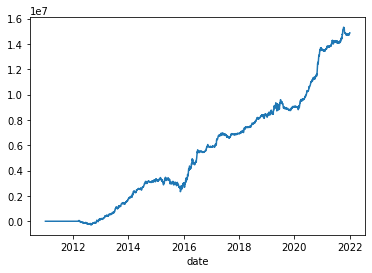

                 tscarry-basmomnma-commod_mkts-170-120-1-0.2
sharp_ratio_10y                                     2.117249
sharp_ratio_1y                                      1.789217
sharp_ratio_2y                                      3.694053
sharp_ratio_3y                                      2.498977
sharp_ratio_4y                                      2.496708
sharp_ratio_5y                                      2.411284
sharp_ratio_6y                                      2.536965
sharp_ratio_7y                                      2.070007
sharp_ratio_8y                                      2.146535
sharp_ratio_9y                                      2.233400
std_pnl_10y                                     45898.793802
std_pnl_1y                                      48473.394058
std_pnl_2y                                      51465.701474
std_pnl_3y                                      56129.426918
std_pnl_4y                                      51960.571819
std_pnl_5y              

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


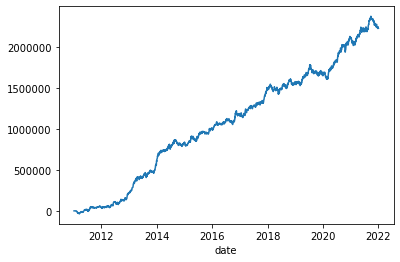

                 xscarry-ryieldnma-commod_mkts-1-20-1-0.2
sharp_ratio_10y                                  1.754754
sharp_ratio_1y                                   0.756451
sharp_ratio_2y                                   1.748539
sharp_ratio_3y                                   1.388579
sharp_ratio_4y                                   1.253840
sharp_ratio_5y                                   1.499793
sharp_ratio_6y                                   1.486903
sharp_ratio_7y                                   1.486020
sharp_ratio_8y                                   1.535940
sharp_ratio_9y                                   1.724376
std_pnl_10y                                   8160.176996
std_pnl_1y                                   10265.751692
std_pnl_2y                                   10800.901815
std_pnl_3y                                   10198.806115
std_pnl_4y                                    9696.679145
std_pnl_5y                                    9308.640294
std_pnl_6y    

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


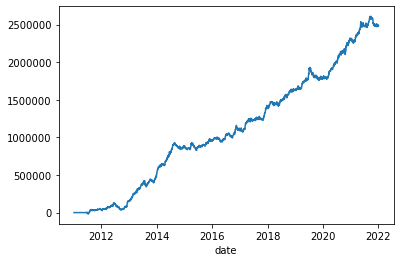

                 xscarry-ryieldnma-commod_mkts-1-110-1-0.2
sharp_ratio_10y                                   2.029787
sharp_ratio_1y                                    1.140319
sharp_ratio_2y                                    2.300506
sharp_ratio_3y                                    1.906260
sharp_ratio_4y                                    1.935452
sharp_ratio_5y                                    2.023300
sharp_ratio_6y                                    1.921733
sharp_ratio_7y                                    1.780894
sharp_ratio_8y                                    1.938483
sharp_ratio_9y                                    2.070035
std_pnl_10y                                    7900.926826
std_pnl_1y                                    10298.043766
std_pnl_2y                                    10009.621111
std_pnl_3y                                     9663.045302
std_pnl_4y                                     9235.727723
std_pnl_5y                                     8998.3444

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


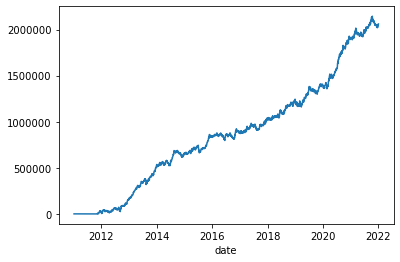

                 xscarry-basmomnma-commod_mkts-80-120-5-0.2
sharp_ratio_10y                                    1.873382
sharp_ratio_1y                                     1.069094
sharp_ratio_2y                                     2.375923
sharp_ratio_3y                                     1.984492
sharp_ratio_4y                                     1.948736
sharp_ratio_5y                                     1.866742
sharp_ratio_6y                                     1.672558
sharp_ratio_7y                                     1.692155
sharp_ratio_8y                                     1.634144
sharp_ratio_9y                                     1.867698
std_pnl_10y                                     7149.695964
std_pnl_1y                                      9163.337101
std_pnl_2y                                      9207.544876
std_pnl_3y                                      8945.356671
std_pnl_4y                                      8624.755454
std_pnl_5y                              

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


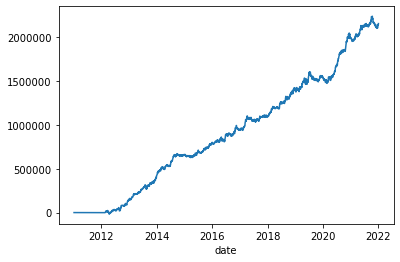

                 xscarry-basmomnma-commod_mkts-150-120-5-0.2
sharp_ratio_10y                                     2.031036
sharp_ratio_1y                                      1.213619
sharp_ratio_2y                                      2.252570
sharp_ratio_3y                                      1.762708
sharp_ratio_4y                                      2.005034
sharp_ratio_5y                                      1.921154
sharp_ratio_6y                                      1.845243
sharp_ratio_7y                                      1.817246
sharp_ratio_8y                                      1.906664
sharp_ratio_9y                                      2.030760
std_pnl_10y                                      6929.918352
std_pnl_1y                                       8735.228239
std_pnl_2y                                       8908.988609
std_pnl_3y                                       9068.223953
std_pnl_4y                                       8653.419643
std_pnl_5y              

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


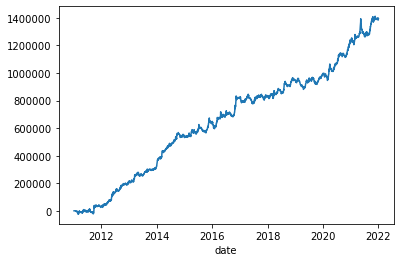

                 tsmom-hlbrk-commod_mkts-10-1-10-0.2
sharp_ratio_10y                             1.698713
sharp_ratio_1y                              1.353808
sharp_ratio_2y                              1.842332
sharp_ratio_3y                              1.553586
sharp_ratio_4y                              1.533201
sharp_ratio_5y                              1.301755
sharp_ratio_6y                              1.406435
sharp_ratio_7y                              1.422582
sharp_ratio_8y                              1.580099
sharp_ratio_9y                              1.609874
std_pnl_10y                              5237.609355
std_pnl_1y                               7943.473228
std_pnl_2y                               7061.911625
std_pnl_3y                               6274.859258
std_pnl_4y                               5948.478051
std_pnl_5y                               5744.337355
std_pnl_6y                               5770.960786
std_pnl_7y                               5640.

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


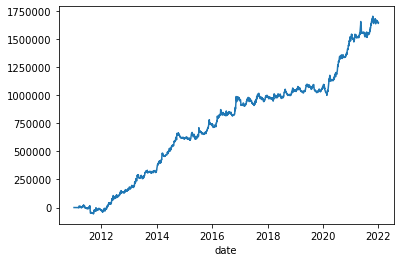

                 tsmom-hlbrk-commod_mkts-30-1-10-0.2
sharp_ratio_10y                             1.629004
sharp_ratio_1y                              1.020376
sharp_ratio_2y                              2.045885
sharp_ratio_3y                              1.646754
sharp_ratio_4y                              1.453807
sharp_ratio_5y                              1.232307
sharp_ratio_6y                              1.341409
sharp_ratio_7y                              1.346586
sharp_ratio_8y                              1.521022
sharp_ratio_9y                              1.568058
std_pnl_10y                              6695.096092
std_pnl_1y                               9572.884092
std_pnl_2y                               9022.209186
std_pnl_3y                               7895.518581
std_pnl_4y                               7393.682643
std_pnl_5y                               7252.919418
std_pnl_6y                               7287.357985
std_pnl_7y                               7133.

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


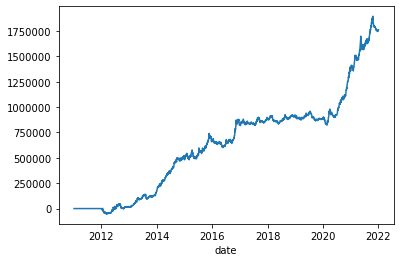

                 tsmom-hlbrk-commod_mkts-240-1-10-0.2
sharp_ratio_10y                              1.601334
sharp_ratio_1y                               2.057490
sharp_ratio_2y                               2.612701
sharp_ratio_3y                               1.966208
sharp_ratio_4y                               1.718273
sharp_ratio_5y                               1.545630
sharp_ratio_6y                               1.528558
sharp_ratio_7y                               1.508806
sharp_ratio_8y                               1.677906
sharp_ratio_9y                               1.707432
std_pnl_10y                               7201.291392
std_pnl_1y                               12490.102744
std_pnl_2y                               10891.337793
std_pnl_3y                                9294.060814
std_pnl_4y                                8347.946358
std_pnl_5y                                7891.285131
std_pnl_6y                                7824.977574
std_pnl_7y                  

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


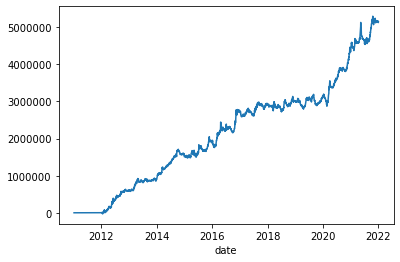

                 tsmom-macdnma-commod_mkts-8-160-5-0.2
sharp_ratio_10y                               1.461198
sharp_ratio_1y                                1.368590
sharp_ratio_2y                                2.035343
sharp_ratio_3y                                1.656752
sharp_ratio_4y                                1.361743
sharp_ratio_5y                                1.233519
sharp_ratio_6y                                1.336419
sharp_ratio_7y                                1.333672
sharp_ratio_8y                                1.411209
sharp_ratio_9y                                1.400648
std_pnl_10y                               22995.936234
std_pnl_1y                                36509.582880
std_pnl_2y                                31981.361421
std_pnl_3y                                28108.398458
std_pnl_4y                                26558.586885
std_pnl_5y                                25627.513268
std_pnl_6y                                25972.384969
std_pnl_7y

<ipython-input-4-029e59ec6bdb>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


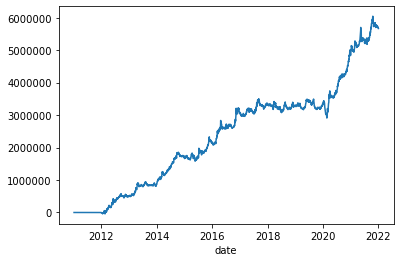

                 tsmom-macdnma-commod_mkts-16-160-5-0.2
sharp_ratio_10y                                1.388170
sharp_ratio_1y                                 1.265756
sharp_ratio_2y                                 1.961045
sharp_ratio_3y                                 1.537632
sharp_ratio_4y                                 1.231951
sharp_ratio_5y                                 1.128059
sharp_ratio_6y                                 1.264246
sharp_ratio_7y                                 1.260655
sharp_ratio_8y                                 1.370710
sharp_ratio_9y                                 1.367312
std_pnl_10y                                26702.445107
std_pnl_1y                                 40229.973757
std_pnl_2y                                 38554.457519
std_pnl_3y                                 33315.436763
std_pnl_4y                                 31061.875129
std_pnl_5y                                 29957.553755
std_pnl_6y                                 30138

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


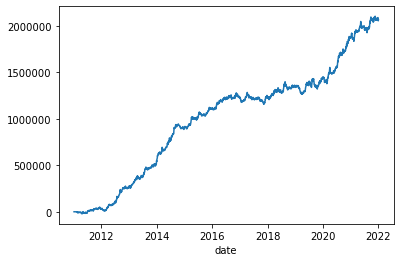

                 xsmom-hlbrk-commod_mkts-20-1-10-0.2
sharp_ratio_10y                             1.868999
sharp_ratio_1y                              1.209456
sharp_ratio_2y                              2.130713
sharp_ratio_3y                              1.710836
sharp_ratio_4y                              1.579552
sharp_ratio_5y                              1.345534
sharp_ratio_6y                              1.307255
sharp_ratio_7y                              1.410293
sharp_ratio_8y                              1.654436
sharp_ratio_9y                              1.789632
std_pnl_10y                              7106.223579
std_pnl_1y                              10205.978113
std_pnl_2y                               9594.011911
std_pnl_3y                               9032.971285
std_pnl_4y                               8560.095943
std_pnl_5y                               8116.344347
std_pnl_6y                               7911.205017
std_pnl_7y                               7600.

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


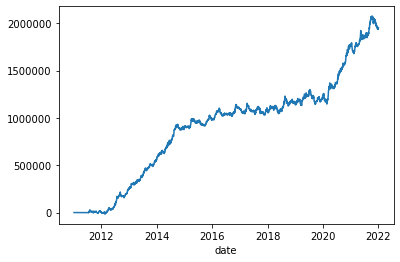

                 xsmom-hlbrk-commod_mkts-120-1-10-0.2
sharp_ratio_10y                              1.565298
sharp_ratio_1y                               1.063820
sharp_ratio_2y                               2.119352
sharp_ratio_3y                               1.637869
sharp_ratio_4y                               1.441409
sharp_ratio_5y                               1.175593
sharp_ratio_6y                               1.148317
sharp_ratio_7y                               1.107756
sharp_ratio_8y                               1.306613
sharp_ratio_9y                               1.469184
std_pnl_10y                               8142.586400
std_pnl_1y                               11419.315664
std_pnl_2y                               11170.017149
std_pnl_3y                               10421.391969
std_pnl_4y                                9920.878951
std_pnl_5y                                9504.673298
std_pnl_6y                                9157.436572
std_pnl_7y                  

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


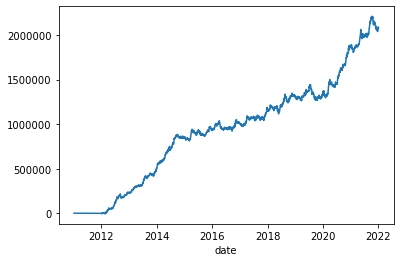

                 xsmom-hlbrk-commod_mkts-240-1-10-0.2
sharp_ratio_10y                              1.730292
sharp_ratio_1y                               1.292331
sharp_ratio_2y                               2.287511
sharp_ratio_3y                               1.668596
sharp_ratio_4y                               1.574085
sharp_ratio_5y                               1.529797
sharp_ratio_6y                               1.396292
sharp_ratio_7y                               1.345425
sharp_ratio_8y                               1.525672
sharp_ratio_9y                               1.655303
std_pnl_10y                               7896.788245
std_pnl_1y                               10894.873406
std_pnl_2y                               10625.837774
std_pnl_3y                                9991.097618
std_pnl_4y                                9601.872275
std_pnl_5y                                9225.108012
std_pnl_6y                                8958.720361
std_pnl_7y                  

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


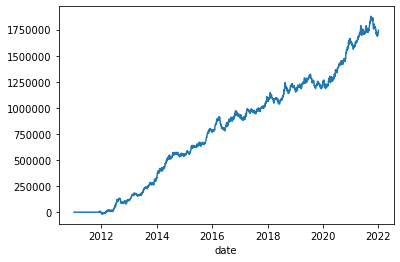

                 xsmom-momnma-commod_mkts-130-90-5-0.2
sharp_ratio_10y                               1.458341
sharp_ratio_1y                                0.711820
sharp_ratio_2y                                1.550927
sharp_ratio_3y                                1.237162
sharp_ratio_4y                                1.136597
sharp_ratio_5y                                1.187969
sharp_ratio_6y                                1.168542
sharp_ratio_7y                                1.283955
sharp_ratio_8y                                1.368823
sharp_ratio_9y                                1.454677
std_pnl_10y                                7864.999919
std_pnl_1y                                10708.532083
std_pnl_2y                                10509.497141
std_pnl_3y                                 9865.576222
std_pnl_4y                                 9466.191845
std_pnl_5y                                 9150.488719
std_pnl_6y                                 8986.195861
std_pnl_7y

<ipython-input-6-a17c550064ca>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['date'] = adf['date']


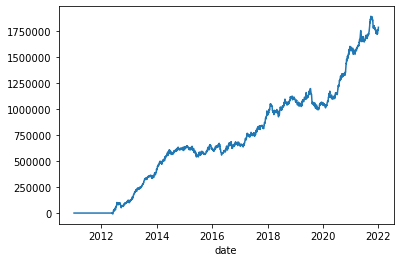

                 xsmom-momnma-commod_mkts-240-90-5-0.2
sharp_ratio_10y                               1.553554
sharp_ratio_1y                                1.334283
sharp_ratio_2y                                2.456856
sharp_ratio_3y                                1.548273
sharp_ratio_4y                                1.459806
sharp_ratio_5y                                1.649752
sharp_ratio_6y                                1.460097
sharp_ratio_7y                                1.300416
sharp_ratio_8y                                1.374160
sharp_ratio_9y                                1.561734
std_pnl_10y                                7504.417697
std_pnl_1y                                10416.330235
std_pnl_2y                                 9931.742334
std_pnl_3y                                 9682.280238
std_pnl_4y                                 9266.510282
std_pnl_5y                                 8936.997775
std_pnl_6y                                 8662.551420
std_pnl_7y

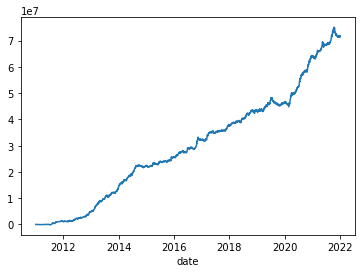

date
2021-11-22    7.191762e+07
2021-11-23    7.175359e+07
2021-11-24    7.192041e+07
2021-11-25    7.194062e+07
2021-11-26    7.175583e+07
2021-11-29    7.166615e+07
2021-11-30    7.137932e+07
2021-12-01    7.146387e+07
2021-12-02    7.138577e+07
2021-12-03    7.155793e+07
2021-12-06    7.164327e+07
2021-12-07    7.180204e+07
2021-12-08    7.162955e+07
2021-12-09    7.148368e+07
2021-12-10    7.147601e+07
2021-12-13    7.129006e+07
2021-12-14    7.134389e+07
2021-12-15    7.134835e+07
2021-12-16    7.137162e+07
2021-12-17    7.131973e+07
2021-12-20    7.129119e+07
2021-12-21    7.141759e+07
2021-12-22    7.132053e+07
2021-12-23    7.136880e+07
2021-12-24    7.174237e+07
2021-12-27    7.154562e+07
2021-12-28    7.163791e+07
2021-12-29    7.146828e+07
2021-12-30    7.162264e+07
2021-12-31    7.172582e+07
Name: daily_pnl, dtype: float64
                             0
sharp_ratio_10y       2.797685
sharp_ratio_1y        2.066577
sharp_ratio_2y        3.434998
sharp_ratio_3y        2.72461

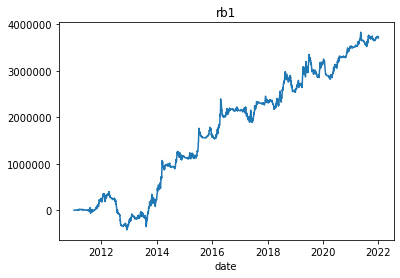

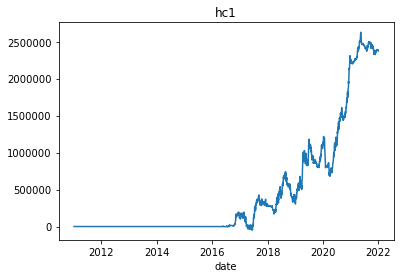

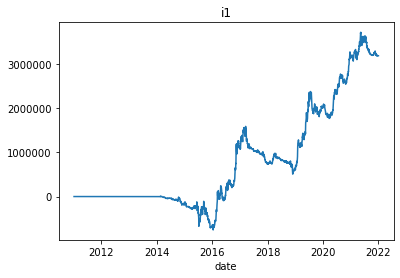

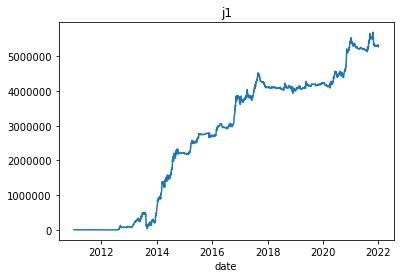

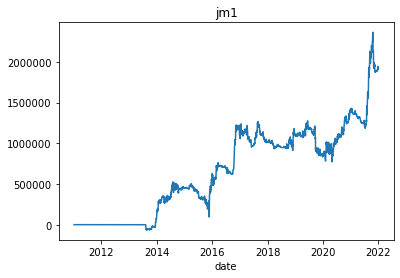

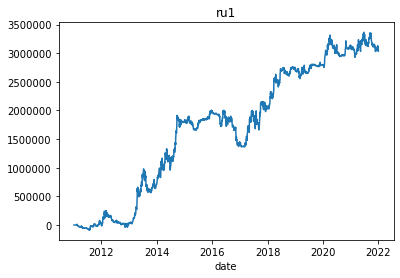

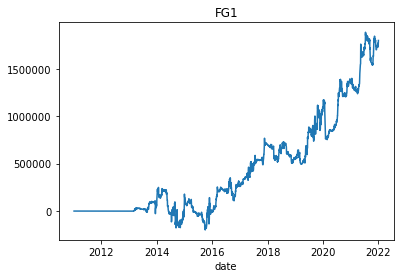

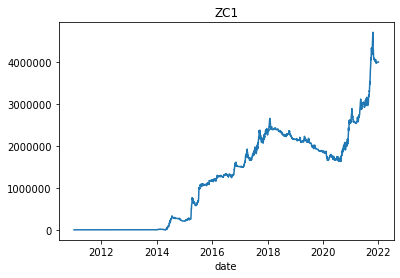

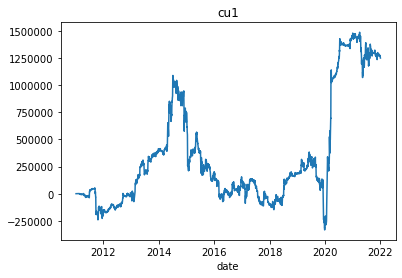

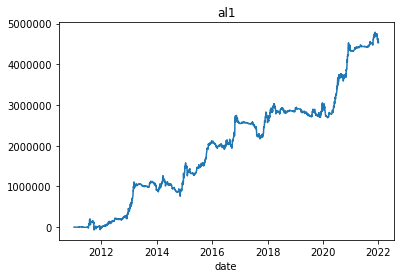

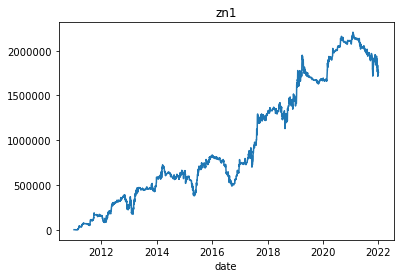

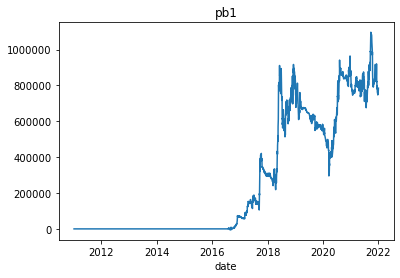

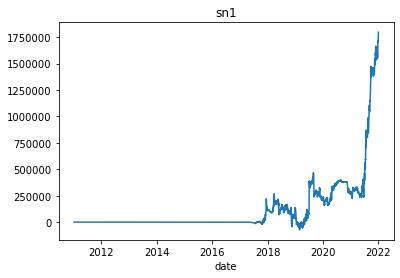

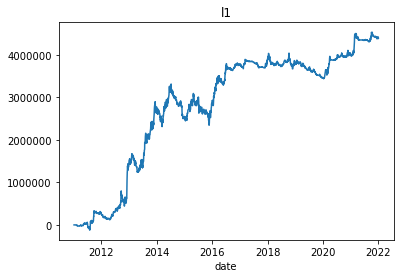

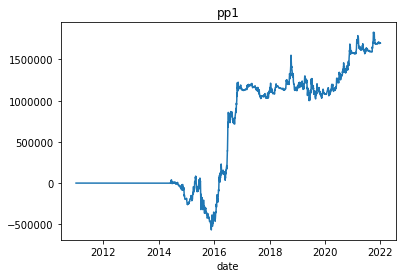

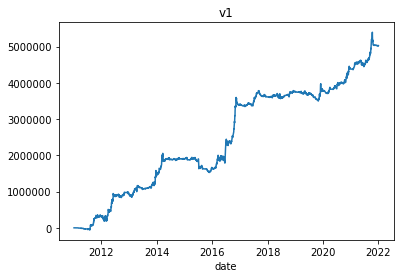

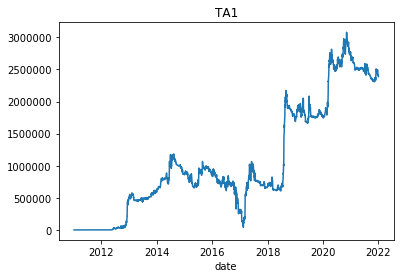

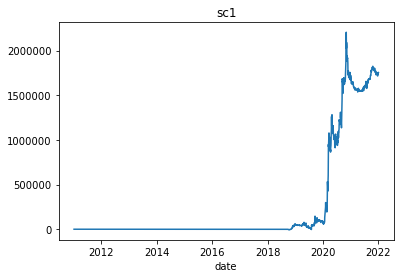

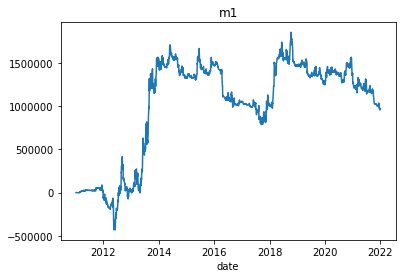

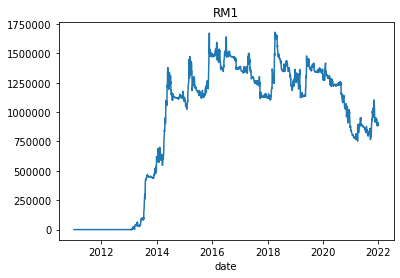

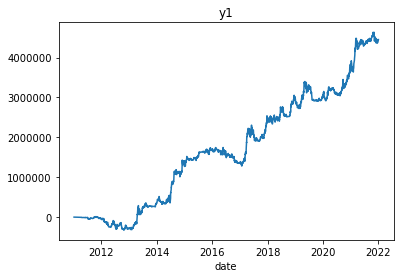

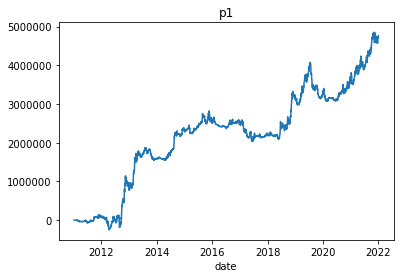

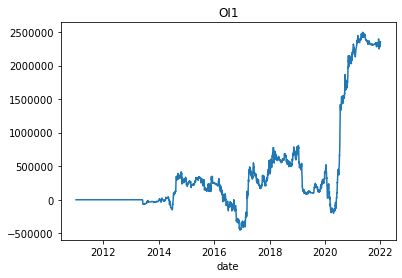

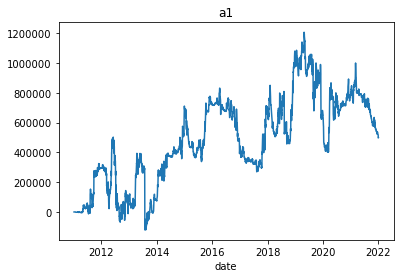

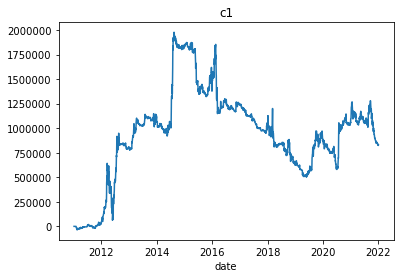

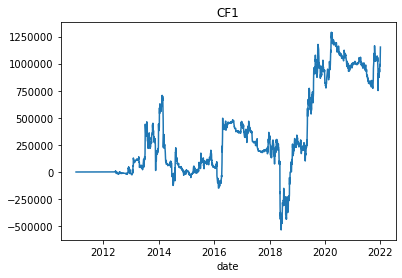

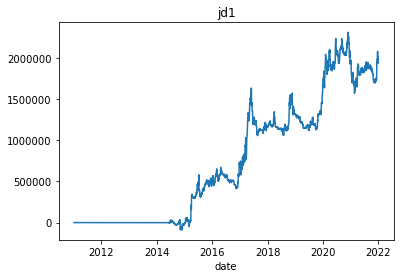

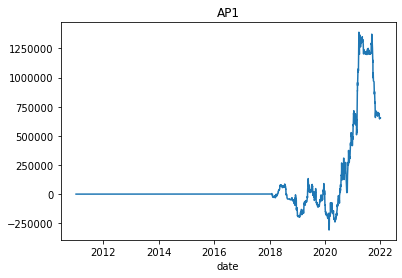

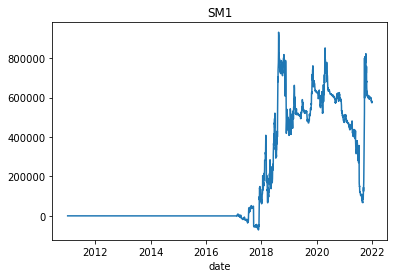

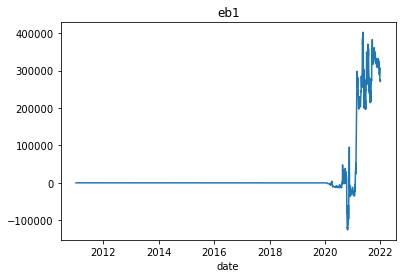

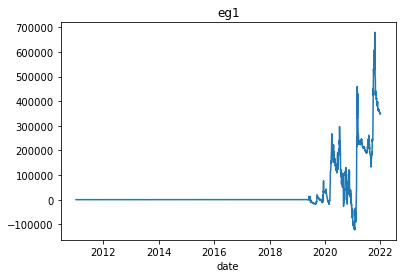

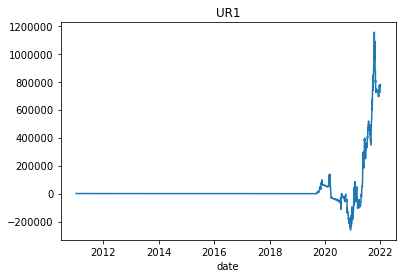

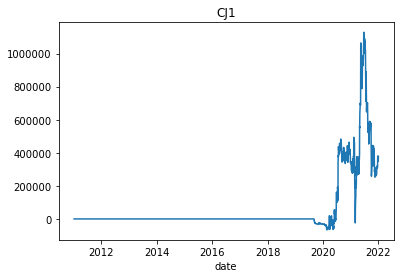

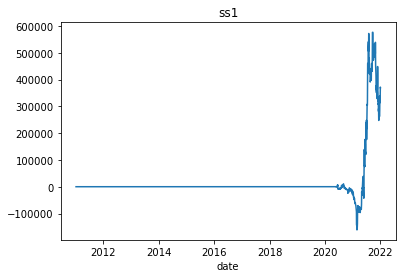

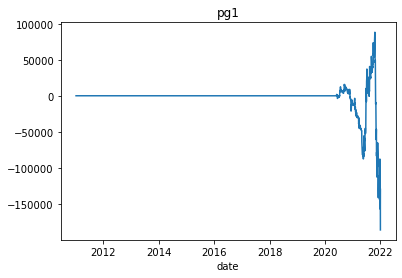

In [8]:
res = {}
stats_list = []
cum_list = []
sratio_years = [int(ten[:-1]) for ten in pnl_tenors]
reverse_list = ['lrkurt']

metal_mixed_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'ni', 'sn', 'ss', 'SM', 'SF']
petro_mixed_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc']
ags_mixed_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd']
commod_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'sn', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM', 'eb', 'eg', 'UR', 'CJ', 'pg', 'SR', 'ni', 'fu', 'lu', 'cs', \
               'bu', 'SF', 'MA', 'SA', 'sp', 'nr']
commod_mkts_p1 = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'sn', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM']
               ## 'au', 'ag', 'b']
commod_mkts_p2 = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'sn', \
               'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
               'AP', 'SM', 'eb', 'eg', 'UR', 'CJ', 'ss', 'pg'] #, 'ni', 'cs', 'SR', 'SF', 'MA']


product_list = commod_mkts_p2 #  metal_mixed_mkts # +  petro_mixed_mkts #  
# # ind_metal_mkts #commod_all_mkts #  ferrous_products_mkts #+ ferrous_mixed_mkts + base_metal_mkts
product_name = 'commod_mkts'

scenarios = scenarios_elite # scenarios_mixed # 

sim_name = 'tscarry'
run_mode = 'nryield'

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2021,12,31)
quantile = 0.2
cost_ratio = 0.5
total_risk = 3000.0
asset_scaling = False
pos_std = 1
std_win = 20
win = 60
ma_win = 120
rebal = 5
params = [0.0, 0.0]
pos_map = (None, {}, '')
exec_field = 'open'
#save_loc = "C:\\dev\\data\\selected_%s_" % ('_'.join([sim_name, run_mode, product_name, str(quant), str(end_date)]))
save_loc = "C:\\dev\\data\\combined_carry_" + product_name + "_" + str(end_date) + '_'

run_pos_sum = True
pos_sum = pd.DataFrame()
dpnl_sum = pd.DataFrame()
pos_list = []


if 'ts' in sim_name:
    sim_func = run_ts_test
elif 'xs' in sim_name:
    sim_func = run_xs_test

port_pnl = pd.Series()
dpnl_by_scen = [] 

for scen in scenarios:
    if len(scen) == 2:
        scen_x = scen[0]
        scen_y = scen[1]
        if run_mode in ['ryield']:
            win = 1
            ma_win = 1
            rebal = scen_y 
            if sim_name == 'xscarry':
                quantile = scen_x * 0.1
        elif run_mode in ['basmom']:
            win = scen_x
            ma_win = 1
            rebal = scen_y
        elif run_mode in ['basmomma']:
            win = scen_x
            ma_win = scen_y
            rebal = 5
        elif run_mode in ['nyield']:
            win = scen_x
            
        elif run_mode == 'ryieldma':
            rebal = scen_y
            ma_win = scen_x
        else:
            print("unsupported run_mode")
            continue
    elif len(scen) >= 8:
        sim_name = scen[0]
        if 'ts' in sim_name:
            sim_func = run_ts_test
        elif 'xs' in sim_name:
            sim_func = run_xs_test
            if len(scen) == 9:
                quantile = scen[8]
        run_mode = scen[1]
        weight = scen[2]
        win = scen[3]
        ma_win = scen[4]
        rebal = scen[5]
        pos_map = scen[6]
        params = scen[7]        
    else:
        print("unsupported scenarios")
        continue
    run_args = {}        
    run_args['run_name'] = run_name = '-'.join([sim_name, run_mode, product_name, str(win), str(ma_win), str(rebal), str(quantile)])
    run_args['cost_ratio'] = cost_ratio
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['exec_field'] = exec_field
    run_args['product_list'] = product_list
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['std_win'] = std_win
    run_args['prefix'] = save_loc        
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    run_args['params'] = params
    run_args['pos_map'] = pos_map
    run_args['run_mode'] = run_mode
    run_args['quantile'] = quantile
    res = sim_func(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    stats_list.append(res['pnl_stats'])
    vdf = res['pnl_stats']
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
    if run_pos_sum:
        pos_list.append(res['pos_df'])
        dpnl_by_scen.append(res['cum_pnl'].diff().dropna())
        pos_sum = pos_sum.add(res['pos_df'] * weight, fill_value = 0) 
        dpnl_sum = dpnl_sum.add(res['dpnl'] * weight, fill_value = 0) 
        port_pnl = port_pnl.add(res['cum_pnl'] * weight, fill_value = 0)

port_pnl.plot()
port_pnl.name = 'daily_pnl'
plt.show()
res_pnl = backtest.pnl_stats_by_tenor(port_pnl.diff().dropna(), tenors = pnl_tenors, field = None)
vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
print(port_pnl[-30:])
print(vdf)
port_pnl.to_csv(file_folder + "port_pnl.csv")
cpnl = dpnl_sum.cumsum()
for col in cpnl.columns:
    cpnl[col].plot(title = col)
    plt.show()


In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { height:200% !important;}</style>"))

          rb-pos      hc-pos       i-pos      j-pos     jm-pos     ru-pos  \
0       0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
1       0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
2       0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
3       0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
4       0.000000    0.000000    0.000000   0.000000   0.000000   0.000000   
...          ...         ...         ...        ...        ...        ...   
2518  116.251255   99.098959   26.893155  13.788628  14.145129  -9.189967   
2519  122.148019   98.122491   51.118245  10.939379  21.958378 -12.584522   
2520  127.861519  100.719599   95.498011   5.114695  31.342067 -18.051788   
2521  107.110826   93.338886  152.998094   9.974778  39.995558 -22.669545   
2522   94.329129   87.810734  176.757550  -2.373315  25.851582 -24.175275   

          FG-pos      ZC-pos    cu-pos     al-pos  ...      RM-pos     y-po

<ipython-input-12-0a172ac03eb7>:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pnl_dict[scen[0]][scen[1]] = pd.Series()


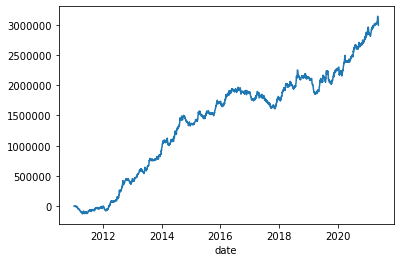

                            0
sharp_ratio_10y      1.495793
sharp_ratio_1y       2.254041
sharp_ratio_2y       1.909702
sharp_ratio_3y       1.276970
sharp_ratio_4y       1.214613
sharp_ratio_5y       0.909643
sharp_ratio_6y       1.093754
sharp_ratio_8y       1.379338
std_pnl_10y      13563.657135
std_pnl_1y       16336.653302
std_pnl_2y       16988.767995
std_pnl_3y       15928.542887
std_pnl_4y       15616.463667
std_pnl_5y       15283.845649
std_pnl_6y       14895.535288
std_pnl_8y       14376.153019
sim_name = xsfact, run_mode = upstdsma


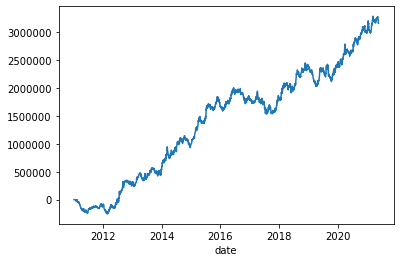

                            0
sharp_ratio_10y      1.183885
sharp_ratio_1y       1.599953
sharp_ratio_2y       1.347924
sharp_ratio_3y       1.109045
sharp_ratio_4y       1.090071
sharp_ratio_5y       0.790669
sharp_ratio_6y       0.962540
sharp_ratio_8y       1.166865
std_pnl_10y      18509.387625
std_pnl_1y       20857.058735
std_pnl_2y       22136.671971
std_pnl_3y       21306.468277
std_pnl_4y       21203.484398
std_pnl_5y       20495.275952
std_pnl_6y       20052.202992
std_pnl_8y       19507.190735
sim_name = xsfact, run_mode = volmfratiosma


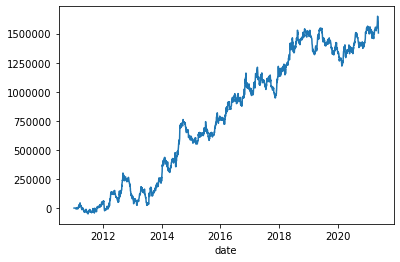

                            0
sharp_ratio_10y      0.757524
sharp_ratio_1y       0.551798
sharp_ratio_2y      -0.082112
sharp_ratio_3y       0.164019
sharp_ratio_4y       0.422507
sharp_ratio_5y       0.526894
sharp_ratio_6y       0.664488
sharp_ratio_8y       0.798237
std_pnl_10y      13228.451805
std_pnl_1y       12703.222301
std_pnl_2y       12566.397856
std_pnl_3y       12876.046370
std_pnl_4y       13745.366358
std_pnl_5y       14696.435414
std_pnl_6y       14358.477669
std_pnl_8y       13968.050183
corr for sim_name = xsfact
          0         1         2
0  1.000000  0.722014  0.494653
1  0.722014  1.000000  0.335202
2  0.494653  0.335202  1.000000
combined pnl for sim_name = xsfact


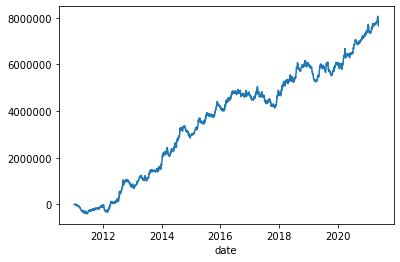

                            0
sharp_ratio_10y      1.371337
sharp_ratio_1y       2.061969
sharp_ratio_2y       1.493406
sharp_ratio_3y       1.143496
sharp_ratio_4y       1.159447
sharp_ratio_5y       0.912007
sharp_ratio_6y       1.106406
sharp_ratio_8y       1.347608
std_pnl_10y      38081.276082
std_pnl_1y       37441.601057
std_pnl_2y       41013.743457
std_pnl_3y       40299.236332
std_pnl_4y       41303.121065
std_pnl_5y       41503.275031
std_pnl_6y       40793.485668
std_pnl_8y       39879.285157
     0
0  1.0
combined pnl for sim_name = xsfact


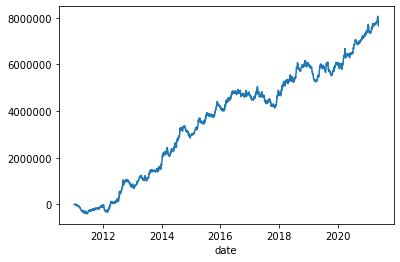

                            0
sharp_ratio_10y      1.371337
sharp_ratio_1y       2.061969
sharp_ratio_2y       1.493406
sharp_ratio_3y       1.143496
sharp_ratio_4y       1.159447
sharp_ratio_5y       0.912007
sharp_ratio_6y       1.106406
sharp_ratio_8y       1.347608
std_pnl_10y      38081.276082
std_pnl_1y       37441.601057
std_pnl_2y       41013.743457
std_pnl_3y       40299.236332
std_pnl_4y       41303.121065
std_pnl_5y       41503.275031
std_pnl_6y       40793.485668
std_pnl_8y       39879.285157


In [12]:
cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'stats.csv')
if run_pos_sum:    
    print(pos_sum)

cutoff_date = datetime.date(2016,1,1)

dpnl_cutoff = []
for dpnl in dpnl_by_scen:
    dpnl_cutoff.append(dpnl[dpnl.index >= cutoff_date])

combo_dpnl = pd.concat(dpnl_cutoff, axis = 1)
combo_dpnl.columns = [ '_'.join([scen[0], scen[1], str(idx)]) for idx, scen in enumerate(scenarios)]
    
combo_dpnl.corr().to_csv(file_folder + "port_corr.csv")
pnl_dict = {}    
for idx, (scen, dpnl) in enumerate(zip(scenarios, dpnl_by_scen)):    
    if scen[0] not in pnl_dict:
        pnl_dict[scen[0]] = {}
    if scen[1] not in pnl_dict[scen[0]]:
        pnl_dict[scen[0]][scen[1]] = pd.Series()
    pnl_dict[scen[0]][scen[1]] = pnl_dict[scen[0]][scen[1]].add(dpnl * scen[2], fill_value = 0)

pnl_by_sim = []
for sim_name in pnl_dict:
    pnl_list = []
    for run_mode in pnl_dict[sim_name]:
        print("sim_name = %s, run_mode = %s" % (sim_name, run_mode))
        pnl_list.append(pnl_dict[sim_name][run_mode])
        cpnl = pnl_dict[sim_name][run_mode].cumsum()        
        cpnl.plot()
        plt.show()
        res_pnl = backtest.pnl_stats_by_tenor(pnl_dict[sim_name][run_mode].dropna(), tenors = pnl_tenors, field = None)
        vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
        vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
        print(vdf)            
    print("corr for sim_name = %s" % sim_name)
    xdf = pd.concat(pnl_list, axis = 1)
    tdf = xdf[xdf.index >= cutoff_date]
    print(tdf.corr())
    print("combined pnl for sim_name = %s" % sim_name)
    adf = xdf.sum(axis=1)
    pnl_by_sim.append(adf)
    adf.cumsum().plot()
    plt.show()
    res_pnl = backtest.pnl_stats_by_tenor(adf.dropna(), tenors = pnl_tenors, field = None)
    vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
xdf = pd.concat(pnl_by_sim, axis = 1)
tdf = xdf[xdf.index >= cutoff_date]
print(tdf.corr())
print("combined pnl for sim_name = %s" % sim_name)
adf = xdf.sum(axis=1)
pnl_by_sim.append(adf)
adf.cumsum().plot()
plt.show()
res_pnl = backtest.pnl_stats_by_tenor(adf.dropna(), tenors = pnl_tenors, field = None)
vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
print(vdf)

In [13]:
save_xl = True
if run_pos_sum and save_xl:
    xlfile = save_loc + "pos_data.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for idx in range(len(pos_list)):            
        pos_list[idx].to_excel(writer, str(idx), startcol= 0, startrow=1)
    pos_sum.to_excel(writer, "sum", startcol= 0, startrow=1)
    writer.save()    


In [9]:
print(df)

           index  rb1-open  rb1-high  rb1-low  rb1-close  rb1-volume  \
0     2011-01-04    2373.0    2386.0   2348.0     2365.0      275428   
1     2011-01-05    2343.0    2360.0   2332.0     2336.0      214902   
2     2011-01-06    2349.0    2368.0   2345.0     2352.0      186136   
3     2011-01-07    2343.0    2371.0   2320.0     2336.0      369032   
4     2011-01-10    2344.0    2394.0   2344.0     2377.0      436038   
...          ...       ...       ...      ...        ...         ...   
2499  2021-04-19    5122.0    5143.0   5058.0     5082.0     2509136   
2500  2021-04-20    5091.0    5171.0   5070.0     5165.0     2137195   
2501  2021-04-21    5158.0    5189.0   5125.0     5188.0     2026507   
2502  2021-04-22    5195.0    5238.0   5175.0     5208.0     2569897   
2503  2021-04-23    5225.0    5300.0   5205.0     5299.0     2115301   

      rb1-openInterest rb1-contract  rb1-shift  rb1-contmth  ...  AP2-open  \
0               576934       rb1105    -2457.0       2011